# TimeGAN - Hands On Lab

### Introduction
A good generative model for time-series data should preserve temporal dynamics,
in the sense that new sequences respect the original relationships between variables across time. Existing methods that bring generative adversarial networks into the sequential setting do not adequately attend to the temporal correlations unique to time-series data. At the same time, supervised models for sequence prediction which allow finer control over network dynamics are inherently deterministic. 

TimeGAN has combined the flexibility of the unsupervised paradigm with the control afforded by supervised training to generate realistic time-series data. For this purpose, a new modules was added which is the autoencoder. This will part in accomplishing the mission of learning an embedding space jointly optimized with both supervised and adversarial objectives.

Released paper in December 2019 presented at NeurIPS by Yoon, Jarrett, and van der Schaar. Paper link https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks.pdf

### Learning Objectives
* Learn the timeGAN network design
* Training TimeGAN
* Explore Evaluation methods for timeGAN 

### Project Workflow

1. Selecting and preparing real and random time series inputs
2. Creating the key TimeGAN model components
3. Defining the various loss functions and training steps used during the three training
phases
4. Running the training loops and logging the results
5. Generating synthetic time series and evaluating the results

### Steps to run this notebook from Colaboratory

This colab will run much faster on GPU. To use a Google Cloud
GPU:

1. Go to `Runtime > Change runtime type`.
1. Click `Hardware accelerator`.
1. Select `GPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.






### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### IMPORTS

In [ ]:
!pip install tqdm
!pip install pandas_datareader==0.7.0
!pip install pandas-datareader --upgrade
!pip install tables
!pip install quandl

  Using cached https://files.pythonhosted.org/packages/cc/5c/ea5b6dcfd0f55c5fb1e37fb45335ec01cceca199b8a79339137f5ed269e0/pandas_datareader-0.7.0-py2.py3-none-any.whl
  Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


  Using cached https://files.pythonhosted.org/packages/22/f1/a02eea03628865c3d4c29849cda8c8a73f43358048aee47d79dfbfa6c6c3/pandas_datareader-0.9.0-py3-none-any.whl
  Found existing installation: pandas-datareader 0.7.0
    Uninstalling pandas-datareader-0.7.0:
      Successfully uninstalled pandas-datareader-0.7.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import random
from pandas_datareader import data
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm
import quandl

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

### CONFIGS

In [ ]:
# Experiments path
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

experiment = 0
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)
hdf_store = results_path / 'TimeSeriesGAN.h5'


# Model Hyperparameters
seq_len = 24
n_seq = 4
batch_size = 128
hidden_dim = 24
num_layers = 3
train_steps = 10000
gamma = 1

# Data
api_key = "Your API KEY"
start_date = '1990-01-01'
end_date = '2019-02-01'

# A fixed random seed is a common "trick" used in ML that allows us to recreate
# the same data when there is a random element involved.
seed = random.seed(30)

### Data understanding and exploration

This practice will use stock market data. The data is available in this [link](https://www.quandl.com/login)

In [ ]:
tickers = ['AAPL', 'IBM', 'MSFT', 'WMT']
data = pd.DataFrame(columns=tickers)
for ticker in tickers:
    data[ticker] = quandl.get('WIKI/' + ticker, start_date=start_date,
    end_date=end_date, api_key=api_key)['Adj. Close']
data.head()

,AAPL,IBM,MSFT,WMT
1990-01-02,1.118093,14.138144,0.410278,4.054211
1990-01-03,1.125597,14.263656,0.412590,4.054211
1990-01-04,1.129499,14.426678,0.424702,4.033561
1990-01-05,1.133101,14.390611,0.414300,3.990541
1990-01-08,1.140605,14.480057,0.420680,4.043886


In [ ]:
data.tail()

,AAPL,IBM,MSFT,WMT
2018-03-21,171.270,156.69,92.48,88.18
2018-03-22,168.845,152.09,89.79,87.14
2018-03-23,164.940,148.89,87.18,85.42
2018-03-26,172.770,153.37,93.78,87.50
2018-03-27,168.340,151.91,89.47,86.05


In [ ]:
data.shape

(7113, 4)

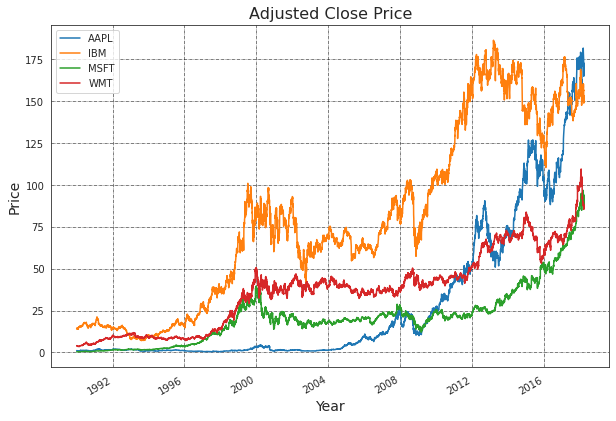

In [ ]:
# Plot all the close prices
data.plot(figsize=(10, 7))
plt.legend()
plt.title("Adjusted Close Price", fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

The dataset contain 7113 Adjusted close price for working week days from 1990-01-02 to 2018-03-27.

### Data Loader: TF API

![alt text](https://drive.google.com/uc?export=view&id=1xe7O6sTg1HxbM_Fc8p57gGXB9keeaDjC)


In [ ]:
# Normalize Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data).astype(np.float32)

In [ ]:
# Create Window Rolling
dataset = []
for i in range(len(data) - 24):
    dataset.append(scaled_data[i:i + 24])

n_windows = len(dataset)

In [ ]:
real_series = (tf.data.Dataset.from_tensor_slices(dataset).shuffle(buffer_size=n_windows).batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [ ]:
# Set up Random Series Generator
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

In [ ]:
random_series = iter(tf.data.Dataset.from_generator(make_random_data, output_types=tf.float32).batch(batch_size).repeat())

In [ ]:
# Fix model inputs
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

### Modeling
![Discriminator.png](https://drive.google.com/uc?export=view&id=1NeG9CjB7hfAg7TlTlWY_kbGSLxAihHXd)

In [ ]:
### RNN block generator
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

#### AutoEncoder

In [ ]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

#### Generator & Discriminator

In [ ]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

### Training Process

Training takes place in three phases:
1. Training the autoencoder on real time series to optimize reconstruction
2. Optimizing the supervised loss using real time series to capture the temporal
dynamics of the historical data
3. Jointly training the four components while minimizing all three loss functions

In [ ]:
## Losses
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [ ]:
autoencoder_optimizer = Adam()
supervisor_optimizer = Adam()
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

#### Phase 1: Autoencoder Training

In [ ]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [ ]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 4)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            9960      
_________________________________________________________________
Recovery (Sequential)        (None, 24, 4)             10900     
Total params: 20,860
Trainable params: 20,860
Non-trainable params: 0
_________________________________________________________________


In [ ]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [ ]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [01:27<00:00, 114.27it/s]


### Phase 2: Supervised training

In [ ]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [ ]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [03:04<00:00, 54.15it/s]


### Phase 3: Joint Training
#### Generator
##### Adversarial Architecture - Supervised

In [ ]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [ ]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 4)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            9960      
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 28,585
Trainable params: 28,585
Non-trainable params: 0
_________________________________________________________________


##### Adversarial Architecture in Latent Space

In [ ]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [ ]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 4)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            9960      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,785
Trainable params: 20,785
Non-trainable params: 0
_________________________________________________________________


#### Mean & Variance Loss

In [ ]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

In [ ]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 4)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            9960      
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Recovery (Sequential)        (None, 24, 4)             10900     
Total params: 28,660
Trainable params: 28,660
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

### Discriminator

In [ ]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [ ]:
discriminator_model.summary()

### Model Training

In [ ]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [ ]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [ ]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.1039 | g_loss_u: 0.6852 | g_loss_s: 0.0004 | g_loss_v: 0.2661 | e_loss_t0: 0.0453
 1,000 | d_loss: 1.8923 | g_loss_u: 1.0490 | g_loss_s: 0.0001 | g_loss_v: 0.0623 | e_loss_t0: 0.0029
 2,000 | d_loss: 1.6644 | g_loss_u: 1.3511 | g_loss_s: 0.0000 | g_loss_v: 0.0237 | e_loss_t0: 0.0031
 3,000 | d_loss: 1.7348 | g_loss_u: 1.2724 | g_loss_s: 0.0001 | g_loss_v: 0.0158 | e_loss_t0: 0.0024
 4,000 | d_loss: 1.4669 | g_loss_u: 1.4065 | g_loss_s: 0.0000 | g_loss_v: 0.0173 | e_loss_t0: 0.0021
 5,000 | d_loss: 1.6910 | g_loss_u: 1.1259 | g_loss_s: 0.0000 | g_loss_v: 0.0229 | e_loss_t0: 0.0021
 6,000 | d_loss: 1.6921 | g_loss_u: 1.2337 | g_loss_s: 0.0001 | g_loss_v: 0.0476 | e_loss_t0: 0.0030
 7,000 | d_loss: 1.7552 | g_loss_u: 1.2347 | g_loss_s: 0.0000 | g_loss_v: 0.0923 | e_loss_t0: 0.0023
 8,000 | d_loss: 1.8204 | g_loss_u: 1.2577 | g_loss_s: 0.0001 | g_loss_v: 0.0568 | e_loss_t0: 0.0025
 9,000 | d_loss: 1.7608 | g_loss_u: 1.1773 | g_loss_s: 0.0001 | g_loss_v: 0.0608 | e_loss_t

#### Generate Synthetic Data

In [ ]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)


55

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(7040, 24, 4)

In [ ]:
np.save(log_dir / 'generated_data.npy', generated_data)

### Rescale

In [ ]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(7040, 24, 4)

In [ ]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq)))

#### Plot sample Series

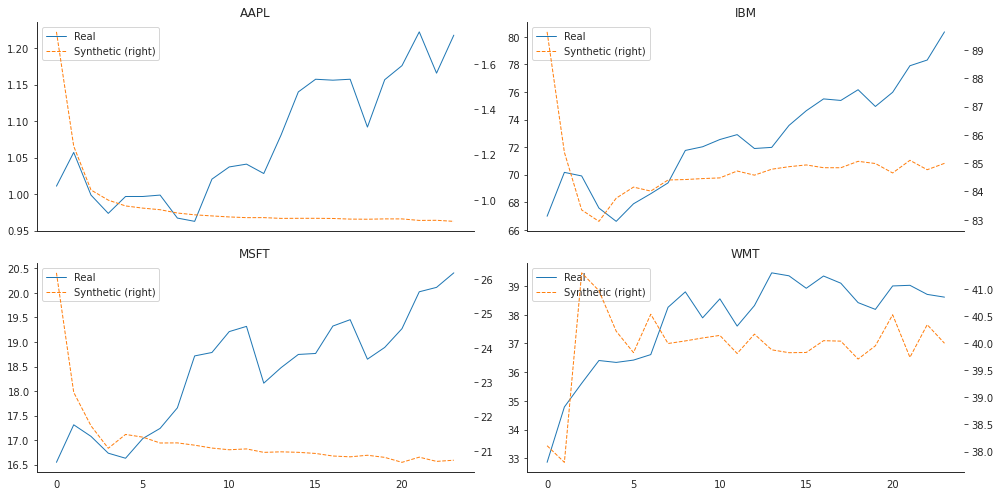

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(data) - seq_len)
real = data.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

### Evaluation Pipeline

In [ ]:
def get_real_data(dataset):

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    data = []
    for i in range(len(dataset) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data(data)

In [ ]:
real_data = real_data[:generated_data.shape[0]]

In [ ]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(generated_data)[idx]

In [ ]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.010s...
[t-SNE] Computed neighbors for 2000 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.063409
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.329220
[t-SNE] KL divergence after 1000 iterations: 0.204649


In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

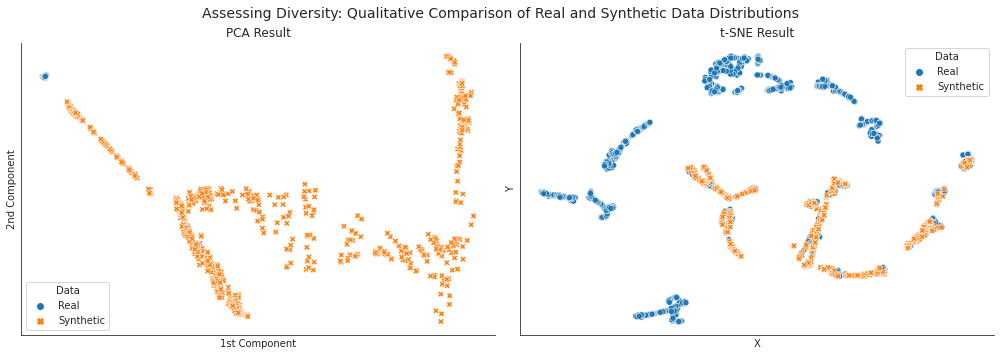

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

#### Refrences:

Book: Machine Learning for algorithmic trading